In [32]:
import random
from geoarray import GeoArray
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import savgol_filter
from scipy.interpolate import splev, splrep
# importing ISOFIT
from isofit.utils import surface_model
from isofit.core.forward import ForwardModel
from isofit.configs.configs import create_new_config
from isofit.inversion.inverse import Inversion
from isofit.core.fileio import IO
import tkinter
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [2]:
cluster = np.loadtxt(r'C:\Users\vpatro\Desktop\Final_Spectra\425\Cl_2.txt')

In [33]:
cluster.shape

(309513, 425)

In [53]:
cluster[:, 105:120] = savgol_filter(cluster[:, 105:120], 11,1, axis = 1)
cluster[:, 140:165] = savgol_filter(cluster[:, 140:165], 21, 1, axis = 1)
cluster[:, 398:419] = savgol_filter(cluster[:, 398:419], 11, 1, axis = 1)

(0.0, 0.65)

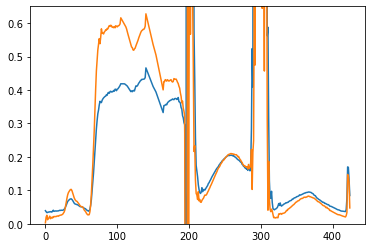

In [61]:
plt.plot(cluster[100000])
plt.plot(cluster[200000])
plt.ylim(0,0.65)

In [54]:
def sample_spectra(cluster_spectra:np.array, num_sets, num_samples):

    sample_sets = []
    
    for i in range(num_sets):
        sample = random.sample(range(0, cluster_spectra.shape[0]), num_samples)
        sample_sets.append(cluster_spectra[sample])
        
    sample_sets = np.array(sample_sets)
        
    return sample_sets

def add_RT_parameters(multi_set_spectra:np.array)-> np.array:
    
    augmented_set = []
    
    H2O = [1.75] * multi_set_spectra.shape[1]
    AOT = [0.05] * multi_set_spectra.shape[1]
    
    H2O = np.array(H2O)[:,None]
    AOT = np.array(AOT)[:,None]
    
    for i in range(multi_set_spectra.shape[0]):
        augmented = np.concatenate((multi_set_spectra[i], AOT), axis = 1)
        augmented = np.concatenate((augmented, H2O), axis = 1)
        augmented_set.append(augmented)
        
    augmented_set = np.array(augmented_set)
    
    return augmented_set

def run_ISOFIT(input_reflectance: np.array) -> np.array:
    
    # Surface model
    surface_model("C:\\Users\\vpatro\\Desktop\\isofit_vp\\examples\\20171108_Pasadena\\configs\\ang20171108t184227_surface.json")

    # Creating ISOFIT objects
    config = create_new_config("C:\\Users\\vpatro\\Desktop\\isofit_vp\\examples\\20171108_Pasadena\\configs\\ang20171108t184227_beckmanlawn.json")
    fm = ForwardModel(config)
    inv = Inversion(config, fm)
    io = IO(config, fm)
    io.get_components_at_index(0, 0)
    geom = io.current_input_data.geom # alternately, call via geom = Geometry()...this won't have data from the above config file
    meas = io.current_input_data.meas  # a numpy  array

    # adding in Radiative Transfer Parameters
    #x = np.loadtxt("C:\\Users\\vpatro\\Desktop\\avirisng_input.txt")
    input_reflectance = np.append(input_reflectance,0.05)
    input_reflectance = np.append(input_reflectance,1.75)
    
    radiance_measurement = fm.calc_rdn(input_reflectance,geom)
    OE_estimation = inv.invert(radiance_measurement, geom)[-1]
    
    return OE_estimation

In [55]:
def remove_bad_bands(spectra: np.array):
    bands = list(range(0,425))
    bands = np.array(bands)
    deeph2o = np.logical_or(np.logical_and(bands > 181, bands < 224), np.logical_and(bands > 275, bands < 329))
    bad_cal = np.logical_or(bands > 418, bands < 3)
    bad = np.logical_or(deeph2o, bad_cal)
    spectra[bad] = np.nan
    
    return spectra

In [56]:
# SavGol smoothening function

def savgol_smoothening(spectra_list:list):
    for spectra in spectra_list:
        noise_peak_1 = spectra[105:120].copy()
        noise_peak_2 = spectra[140:165].copy()
        jagged_peak = spectra[398:419].copy()
        spectra[105:120] = savgol_filter(noise_peak_1, 11,1)
        spectra[140:165] = savgol_filter(noise_peak_2, 21, 1)
        spectra[398:419] = savgol_filter(jagged_peak, 11, 1)
        

In [57]:
# Appending RT parameters
sample_sets = sample_spectra(cluster, 5, 100)
print(sample_sets.shape)
augmented_sets = add_RT_parameters(sample_sets)
print(augmented_sets.shape)

(5, 100, 425)
(5, 100, 427)


In [62]:
l2norms = []
residuals = []
inputs = []
outputs = []

In [63]:
for i in range(5):
    for j in range(100):
        input_vec = augmented_sets[i][j].copy()
        inputs.append(input_vec)
        OE_estimation = run_ISOFIT(input_vec)
        outputs.append(OE_estimation)
        l2norm = np.linalg.norm(input_vec - OE_estimation)
        l2norms.append(l2norm)
        residual = input_vec-OE_estimation
        residuals.append(residual)


In [64]:
len(outputs)

500

In [67]:
inputs= np.array(inputs)
outputs= np.array(outputs)

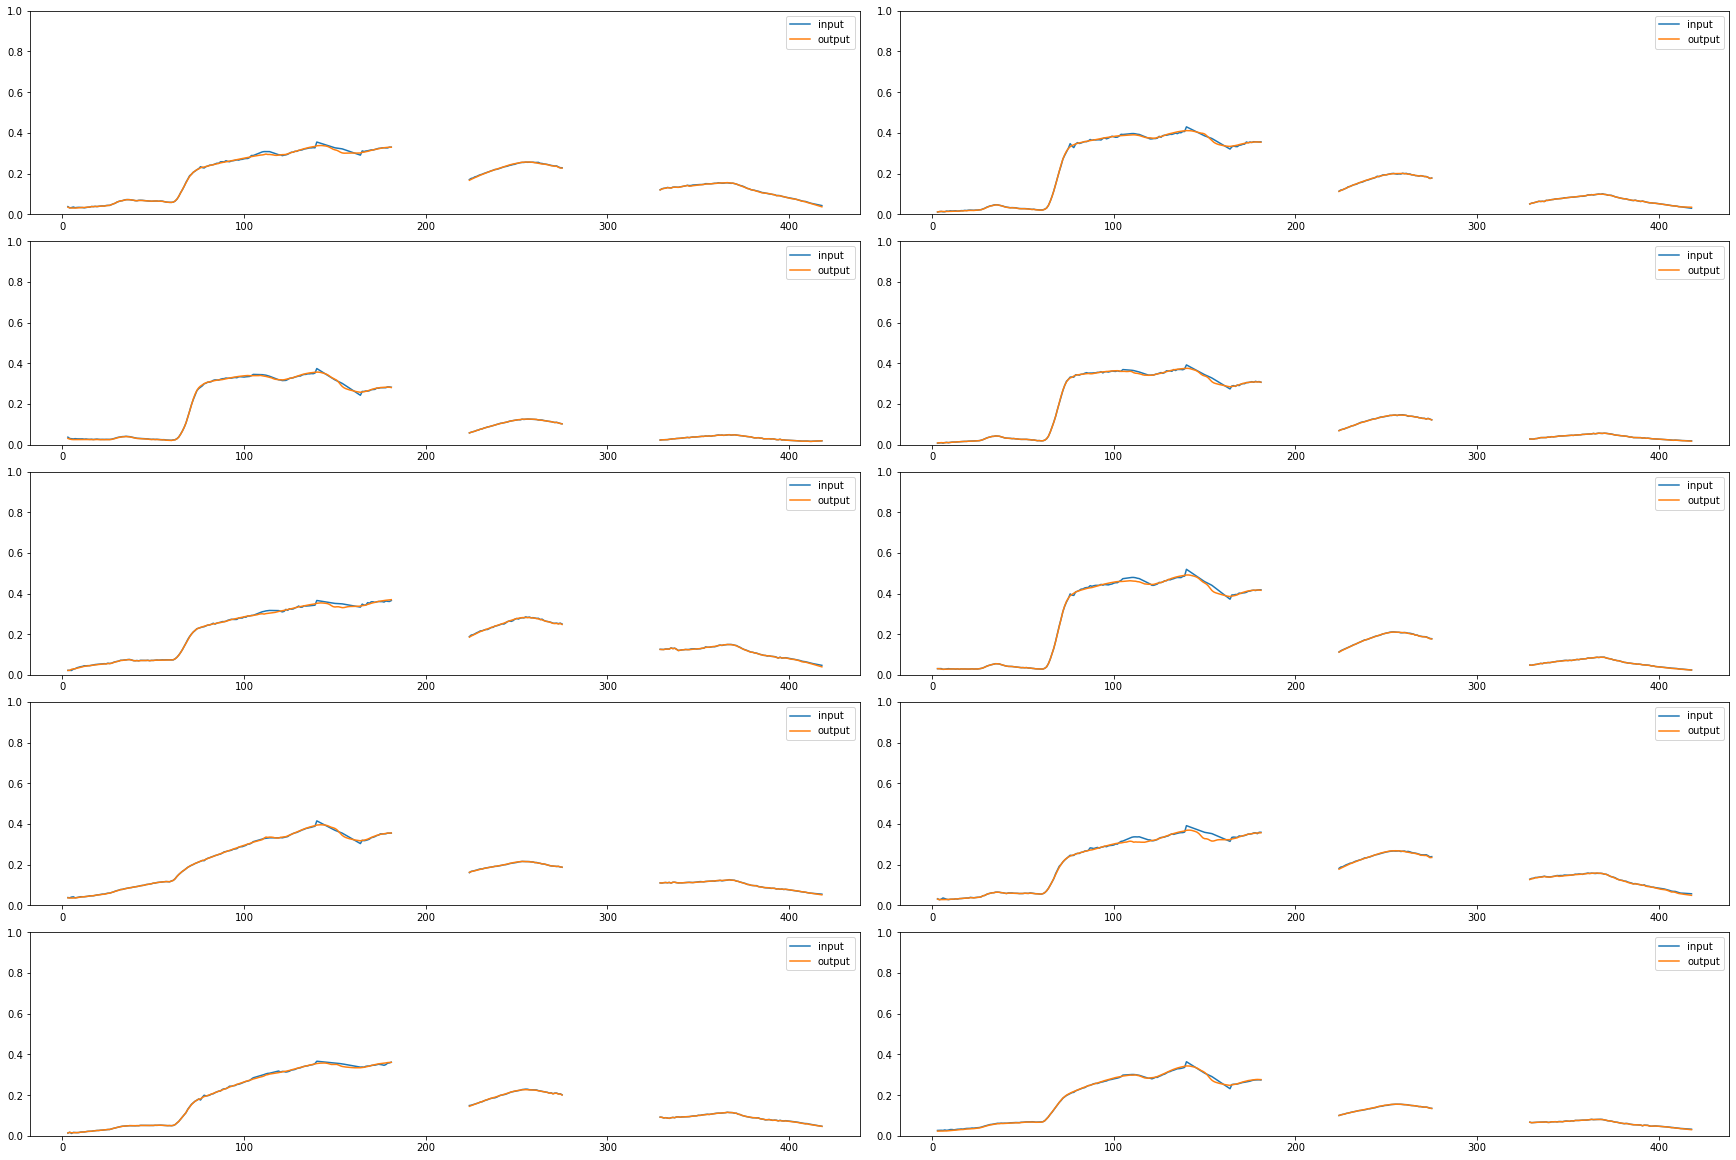

In [68]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (24,16), constrained_layout = True)

count = 0
row = 0
col = 0
for i in range(0,100,10):
    if col == 2:
        row +=1
        col = 0
    cleaned_input = remove_bad_bands(inputs[i,:425].copy())
    cleaned_output = remove_bad_bands(outputs[i][:425].copy())
    axs[row,col].plot(cleaned_input, label = 'input')
    axs[row,col].plot(cleaned_output, label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,1)
    col+= 1

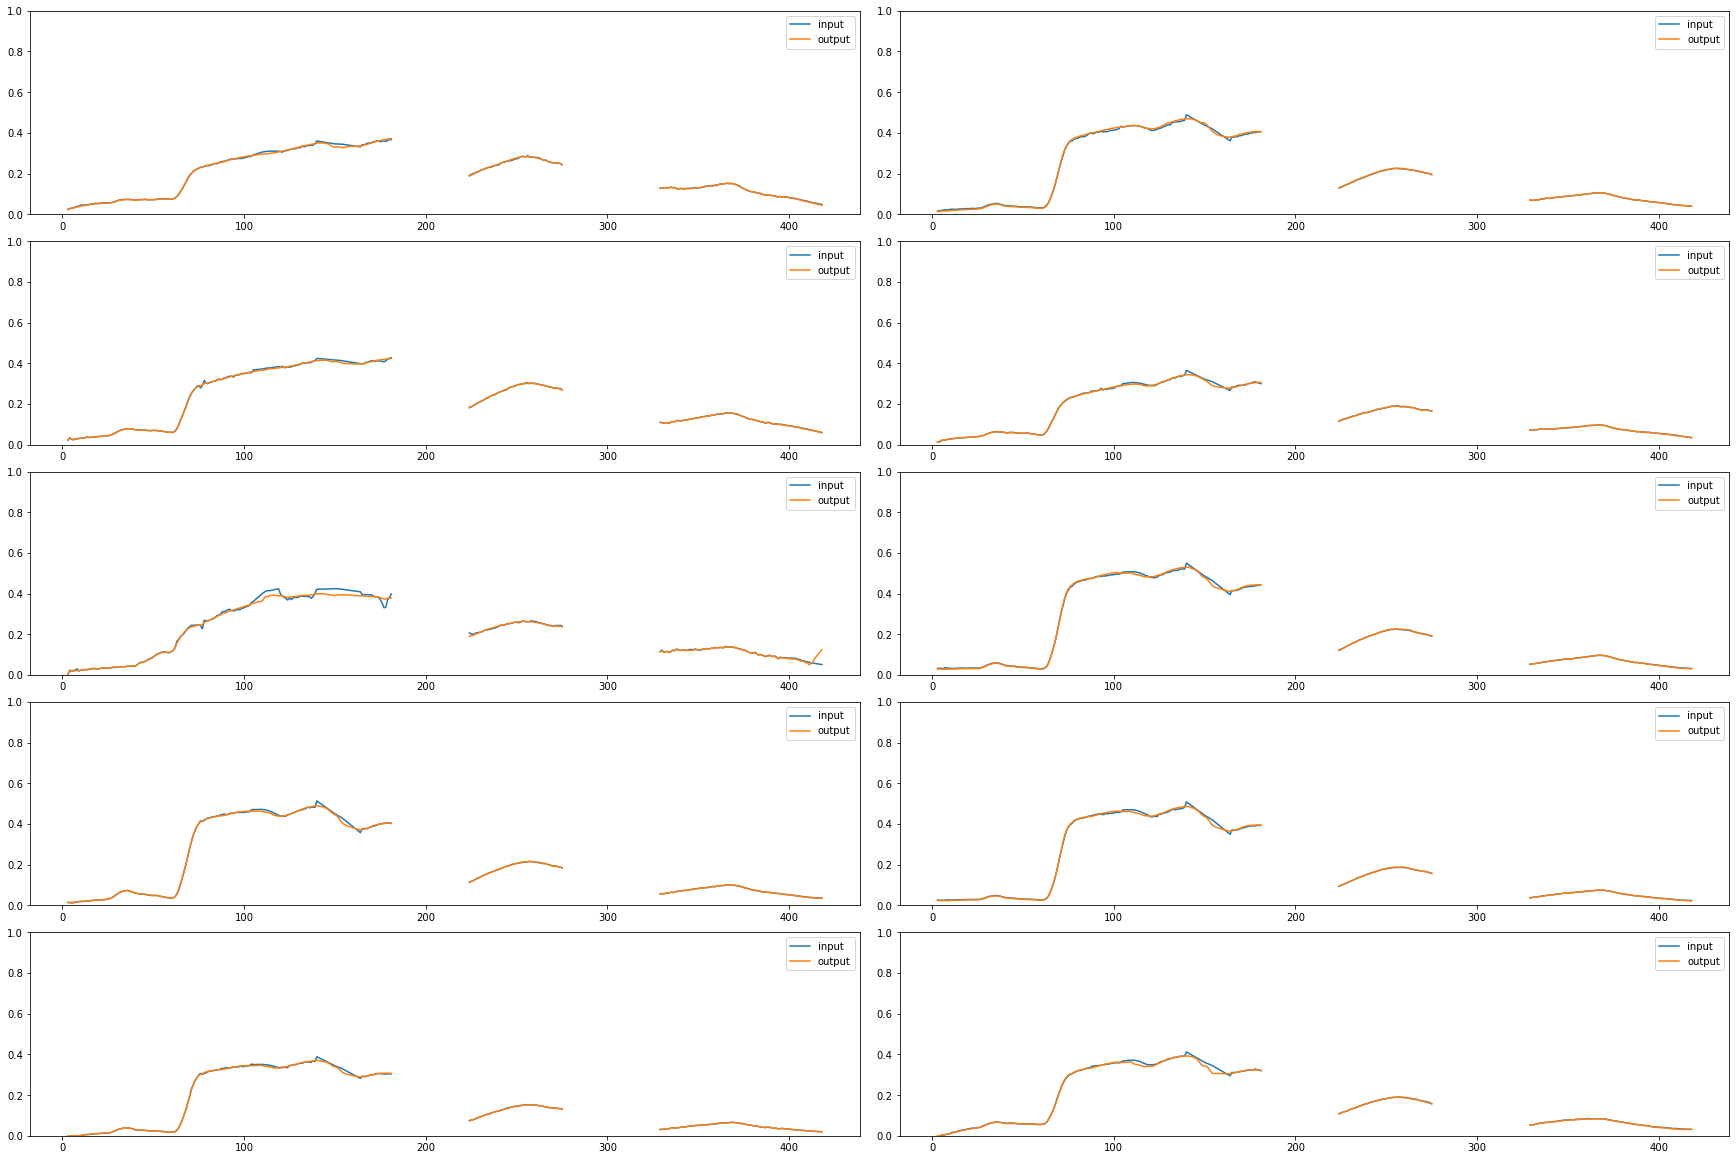

In [69]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (24,16), constrained_layout = True)

count = 0
row = 0
col = 0
for i in range(100,200,10):
    if col == 2:
        row +=1
        col = 0
    cleaned_input = remove_bad_bands(inputs[i,:425].copy())
    cleaned_output = remove_bad_bands(outputs[i][:425].copy())
    axs[row,col].plot(cleaned_input, label = 'input')
    axs[row,col].plot(cleaned_output, label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,1)
    col+= 1


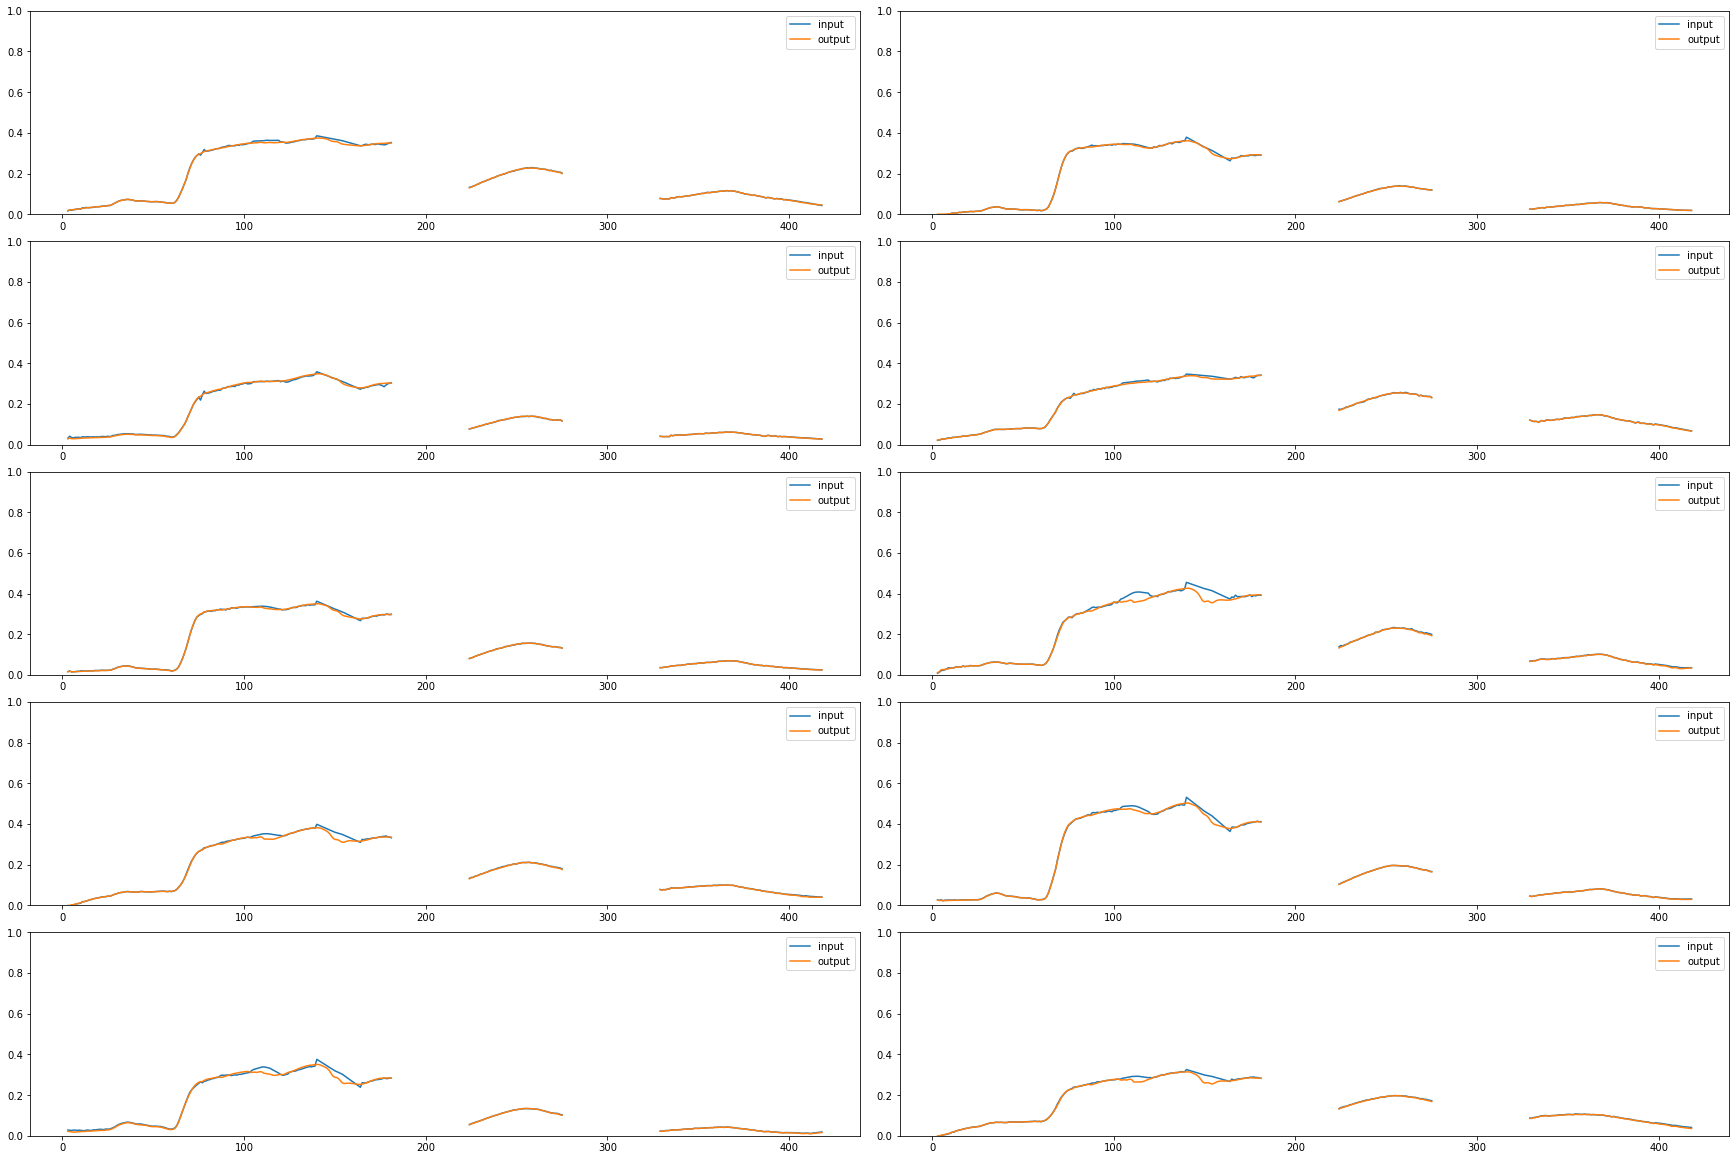

In [70]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (24,16), constrained_layout = True)

count = 0
row = 0
col = 0
for i in range(200,300,10):
    if col == 2:
        row +=1
        col = 0
    cleaned_input = remove_bad_bands(inputs[i,:425].copy())
    cleaned_output = remove_bad_bands(outputs[i][:425].copy())
    axs[row,col].plot(cleaned_input, label = 'input')
    axs[row,col].plot(cleaned_output, label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,1)
    col+= 1


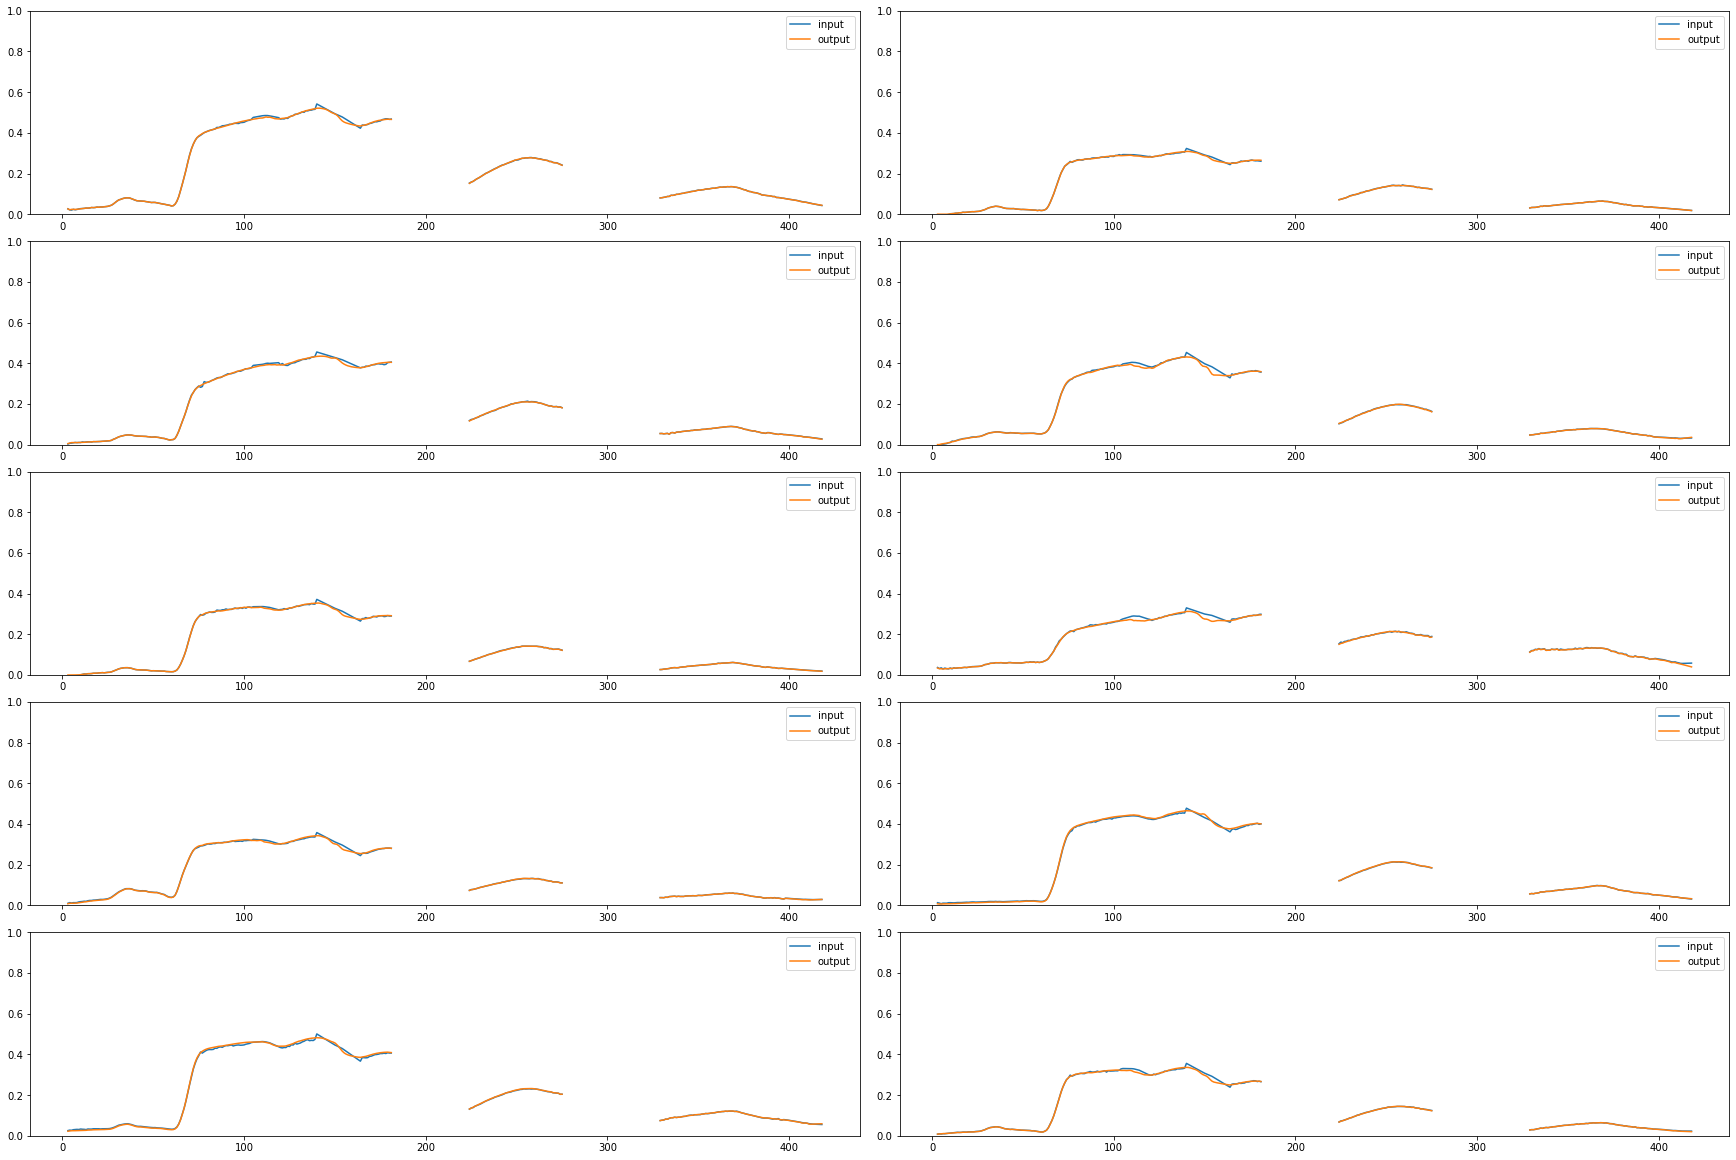

In [71]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (24,16), constrained_layout = True)

count = 0
row = 0
col = 0
for i in range(300,400,10):
    if col == 2:
        row +=1
        col = 0
    cleaned_input = remove_bad_bands(inputs[i,:425].copy())
    cleaned_output = remove_bad_bands(outputs[i][:425].copy())
    axs[row,col].plot(cleaned_input, label = 'input')
    axs[row,col].plot(cleaned_output, label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,1)
    col+= 1


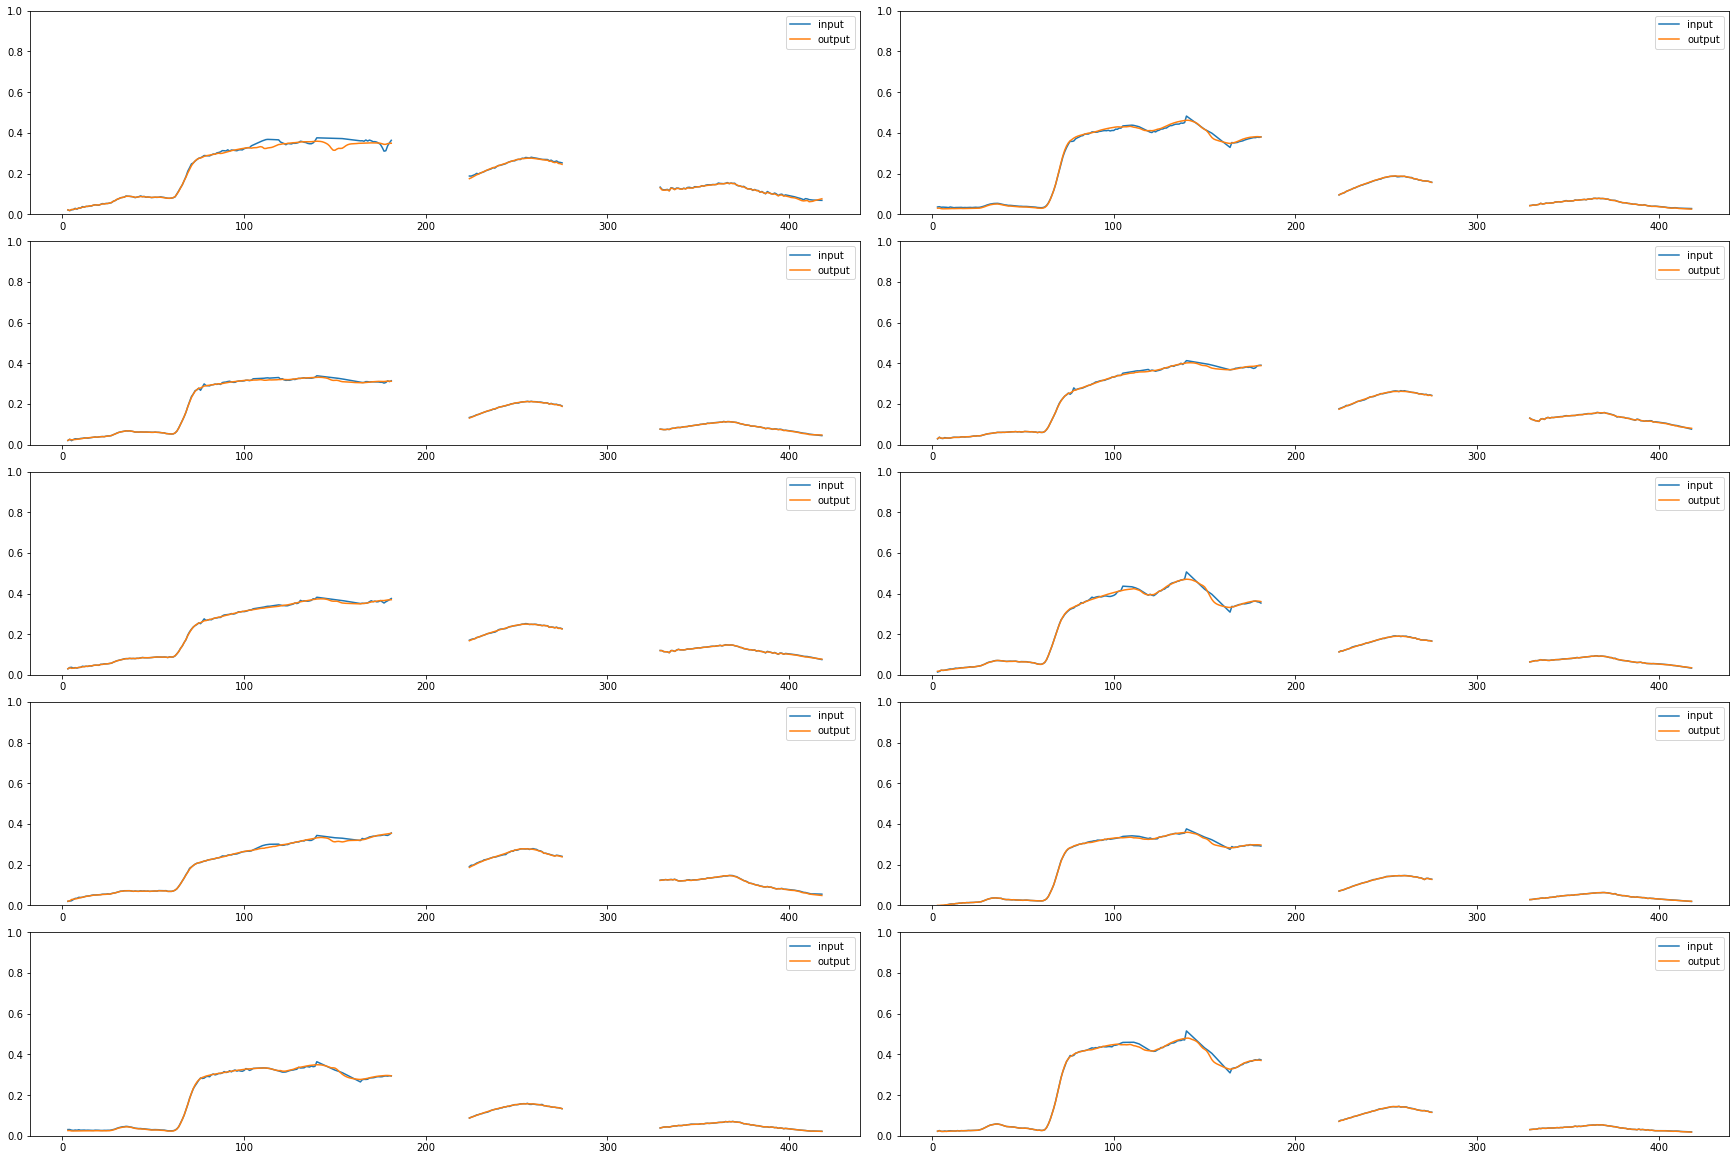

In [72]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (24,16), constrained_layout = True)

count = 0
row = 0
col = 0
for i in range(400,500,10):
    if col == 2:
        row +=1
        col = 0
    cleaned_input = remove_bad_bands(inputs[i,:425].copy())
    cleaned_output = remove_bad_bands(outputs[i][:425].copy())
    axs[row,col].plot(cleaned_input, label = 'input')
    axs[row,col].plot(cleaned_output, label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,1)
    col+= 1


Text(0.5, 1.0, 'Covariance of Residuals')

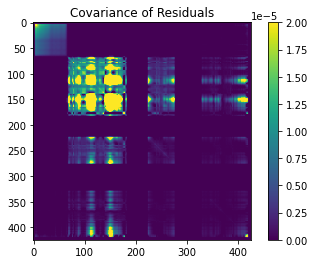

In [73]:
residuals = np.array(residuals)
res_cov = residuals[:,:425].copy()
bands = list(range(0,425))
bands = np.array(bands)
deeph2o = np.logical_or(np.logical_and(bands > 181, bands < 224), np.logical_and(bands > 275, bands < 329))
bad_cal = np.logical_or(bands < 4, bands > 418)
bad = np.logical_or(deeph2o, bad_cal)
res_cov[:, bad] = 0

Cov = np.cov(res_cov, rowvar=False)

plt.imshow(Cov)
plt.colorbar()
plt.clim(0,0.00002)
plt.title('Covariance of Residuals')

In [51]:
inputs = np.array(inputs)
outputs = np.array(outputs)

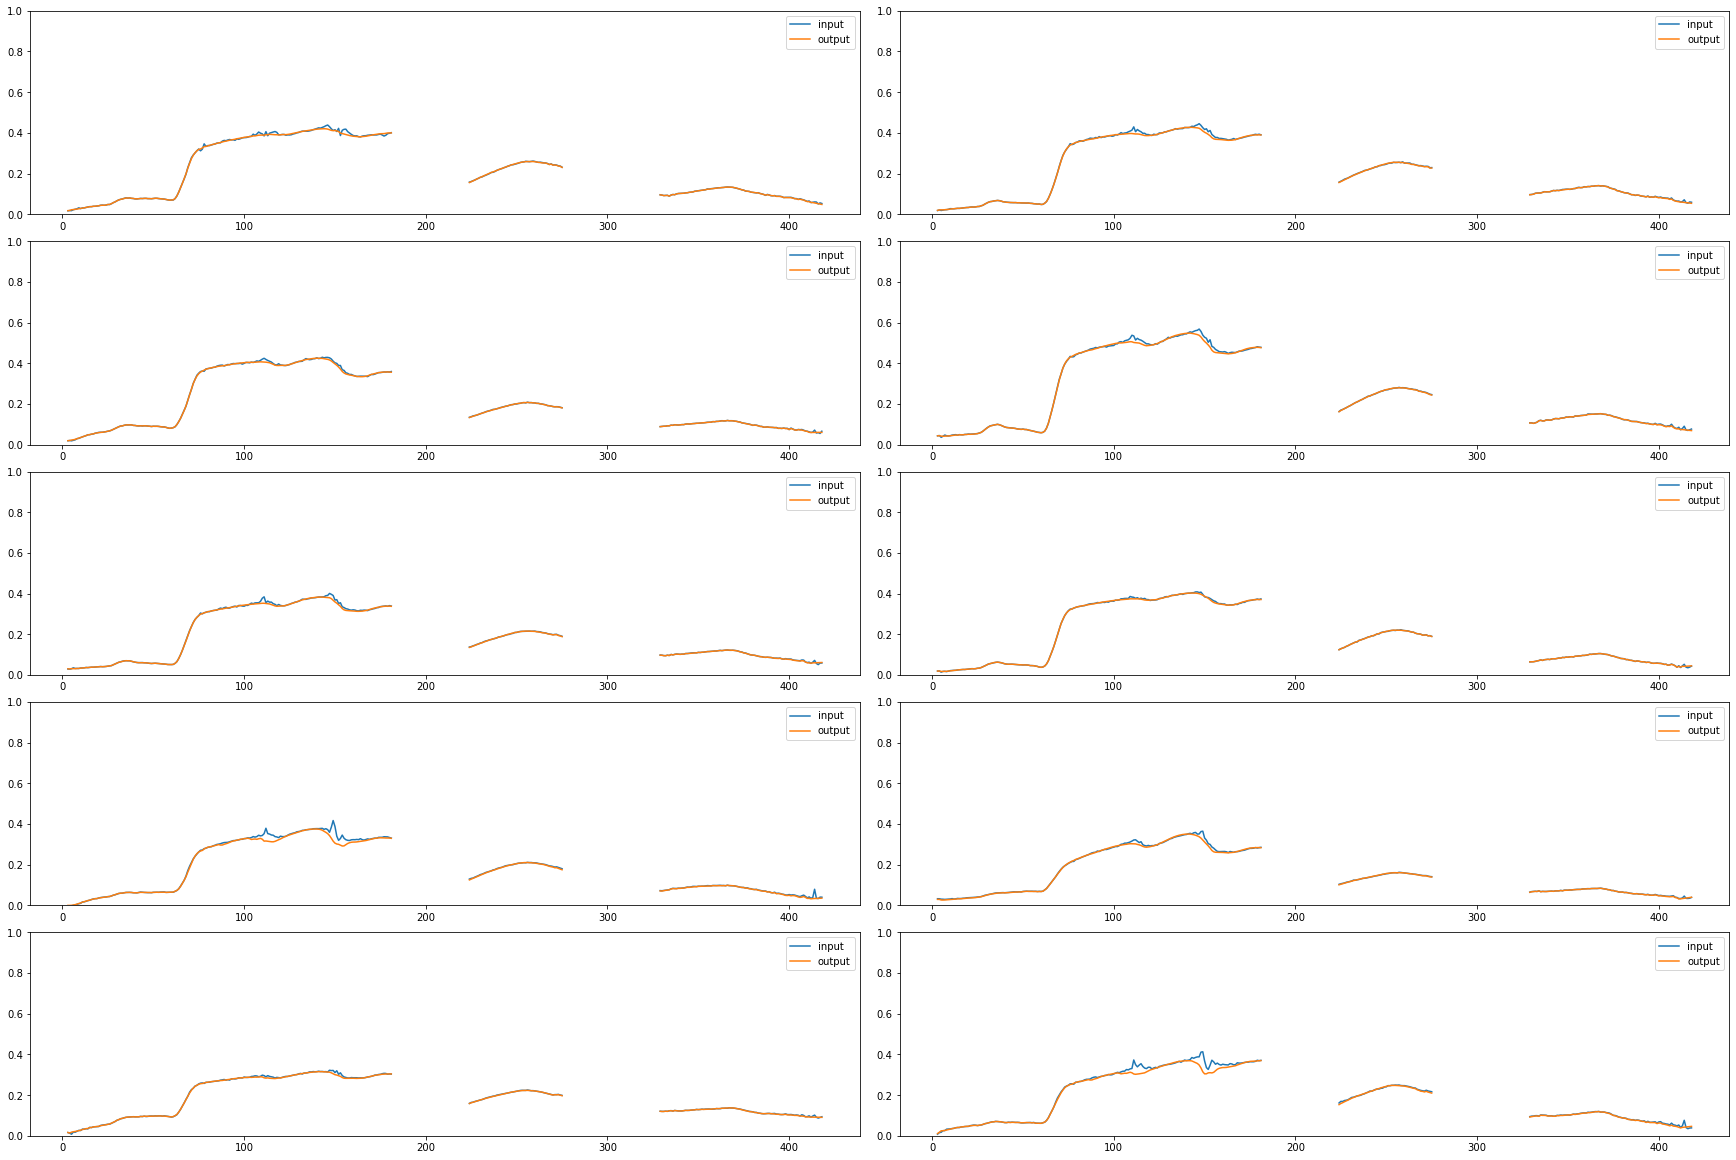

In [52]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (24,16), constrained_layout = True)

count = 0
row = 0
col = 0
for i in range(0,100,10):
    if col == 2:
        row +=1
        col = 0
    cleaned_input = remove_bad_bands(inputs[i,:425].copy())
    cleaned_output = remove_bad_bands(outputs[i][:425].copy())
    axs[row,col].plot(cleaned_input, label = 'input')
    axs[row,col].plot(cleaned_output, label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,1)
    col+= 1


In [13]:
np.savetxt(r'C:\Users\vpatro\Desktop\cluster2_subset.txt', augmented_sets[0])